# Day 17

## Part 1

The lava starts flowing rapidly once the Lava Production Facility is operational. As you leave, the reindeer offers you a parachute, allowing you to quickly reach Gear Island.

As you descend, your bird's-eye view of Gear Island reveals why you had trouble finding anyone on your way up: half of Gear Island is empty, but the half below you is a giant factory city!

You land near the gradually-filling pool of lava at the base of your new lavafall. Lavaducts will eventually carry the lava throughout the city, but to make use of it immediately, Elves are loading it into large crucibles on wheels.

The crucibles are top-heavy and pushed by hand. Unfortunately, the crucibles become very difficult to steer at high speeds, and so it can be hard to go in a straight line for very long.

To get Desert Island the machine parts it needs as soon as possible, you'll need to find the best way to get the crucible from the lava pool to the machine parts factory. To do this, you need to minimize heat loss while choosing a route that doesn't require the crucible to go in a straight line for too long.

Fortunately, the Elves here have a map (your puzzle input) that uses traffic patterns, ambient temperature, and hundreds of other parameters to calculate exactly how much heat loss can be expected for a crucible entering any particular city block.

For example:

```
2413432311323
3215453535623
3255245654254
3446585845452
4546657867536
1438598798454
4457876987766
3637877979653
4654967986887
4564679986453
1224686865563
2546548887735
4322674655533
```
Each city block is marked by a single digit that represents the amount of heat loss if the crucible enters that block. The starting point, the lava pool, is the top-left city block; the destination, the machine parts factory, is the bottom-right city block. (Because you already start in the top-left block, you don't incur that block's heat loss unless you leave that block and then return to it.)

Because it is difficult to keep the top-heavy crucible going in a straight line for very long, it can move at most three blocks in a single direction before it must turn 90 degrees left or right. The crucible also can't reverse direction; after entering each city block, it may only turn left, continue straight, or turn right.

One way to minimize heat loss is this path:

```
2>>34^>>>1323
32v>>>35v5623
32552456v>>54
3446585845v52
4546657867v>6
14385987984v4
44578769877v6
36378779796v>
465496798688v
456467998645v
12246868655<v
25465488877v5
43226746555v>
```
This path never moves more than three consecutive blocks in the same direction and incurs a heat loss of only 102.

Directing the crucible from the lava pool to the machine parts factory, but not moving more than three consecutive blocks in the same direction, what is the least heat loss it can incur?

In [40]:
from dataclasses import dataclass

import pandas as pd


@dataclass
class PathState:
    heat_loss: int = 0
    position: tuple[int, int] = (0, 0)
    direction: str = "east"
    steps_since_turn: int = 0
    previous_state: "PathState" = None


class CruciblePusher:
    def __init__(self, df: pd.DataFrame):
        self.df = df

        self.start_position: tuple[int, int] = (0, 0)
        self.end_position: tuple[int, int] = (df.shape[0] - 1, df.shape[1] - 1)

        self.state_keys = set()

    def north_position(self, from_position: tuple[int, int]) -> tuple[int, int] | None:
        if from_position[0] == 0:
            # at the top row
            return None
        return from_position[0] - 1, from_position[1]

    def south_position(self, from_position: tuple[int, int]) -> tuple[int, int] | None:
        if from_position[0] == self.df.shape[0] - 1:
            # at the bottom row
            return None
        return from_position[0] + 1, from_position[1]

    def east_position(self, from_position: tuple[int, int]) -> tuple[int, int] | None:
        if from_position[1] == self.df.shape[1] - 1:
            # at the rightmost column
            return None
        return from_position[0], from_position[1] + 1

    def west_position(self, from_position: tuple[int, int]) -> tuple[int, int] | None:
        if from_position[1] == 0:
            # at the leftmost column
            return None
        return from_position[0], from_position[1] - 1

    def get_available_moves(self, from_state: PathState) -> dict[str, tuple[int, int]]:
        moves = {}
        directions = {
            "north": "south",
            "south": "north",
            "east": "west",
            "west": "east",
        }
        for direction, opposite_direction in directions.items():
            if from_state.direction == opposite_direction:
                # can't go backwards
                continue
            if from_state.direction == direction and from_state.steps_since_turn == 2:
                # can't go forward if we've already gone 3 steps
                continue
            dir_position = getattr(self, f"{direction}_position")
            if next_position := dir_position(from_state.position):
                moves[direction] = next_position
        return moves

    def calc_lowest_heat_loss(self, from_position: tuple[int, int], direction: str) -> int:
        start_state = PathState(
            heat_loss=0,
            position=from_position,
            direction=direction,
            steps_since_turn=0,
        )
        path_states = [start_state]

        while path_states:
            current_state = path_states.pop(0)
            if current_state.position == self.end_position:
                # hooray, we did it. return the heat loss and work backwards to get the path taken
                final_heat_loss = current_state.heat_loss

                path_taken = []
                while current_state is not None:
                    path_taken.append(current_state.position)
                    current_state: PathState = current_state.previous_state
                path_taken.reverse()

                return final_heat_loss, path_taken

            available_moves = self.get_available_moves(current_state)
            for to_direction, to_position in available_moves.items():
                heat_loss = current_state.heat_loss + self.df.iloc[to_position]

                steps_since_turn = current_state.steps_since_turn
                if to_direction == current_state.direction:
                    steps_since_turn += 1
                else:
                    # reset the steps since last turn
                    steps_since_turn = 0

                next_state = PathState(
                    heat_loss=heat_loss,
                    position=to_position,
                    direction=to_direction,
                    steps_since_turn=steps_since_turn,
                    previous_state=current_state,
                )
                # easier lookup than using a dataclass
                state_key = (
                    f"{next_state.position}{next_state.direction}{next_state.steps_since_turn}"
                )
                if state_key not in self.state_keys:
                    path_states.append(next_state)
                    self.state_keys.add(state_key)

                path_states = sorted(path_states, key=lambda s: s.heat_loss)

        # no path found
        return -1, []


def str_to_df(string: str) -> pd.DataFrame:
    return pd.DataFrame([[int(v) for v in row] for row in string.splitlines()])


test_input = """
2413432311323
3215453535623
3255245654254
3446585845452
4546657867536
1438598798454
4457876987766
3637877979653
4654967986887
4564679986453
1224686865563
2546548887735
4322674655533""".strip()

test_df = str_to_df(test_input)
test_pusher = CruciblePusher(test_df)
test_heat_loss, test_path = test_pusher.calc_lowest_heat_loss(test_pusher.start_position, "east")
assert test_heat_loss == 102

In [41]:
test_path

[(0, 0),
 (0, 1),
 (0, 2),
 (1, 2),
 (1, 3),
 (1, 4),
 (1, 5),
 (0, 5),
 (0, 6),
 (0, 7),
 (0, 8),
 (1, 8),
 (2, 8),
 (2, 9),
 (2, 10),
 (3, 10),
 (4, 10),
 (4, 11),
 (5, 11),
 (6, 11),
 (7, 11),
 (7, 12),
 (8, 12),
 (9, 12),
 (10, 12),
 (10, 11),
 (11, 11),
 (12, 11),
 (12, 12)]

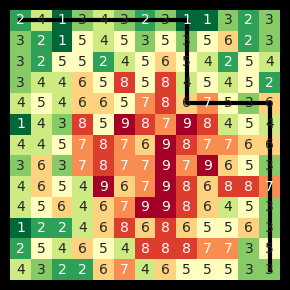

In [84]:
import matplotlib.pyplot as plt
import seaborn as sns


def plot_heatmap(df: pd.DataFrame, path: list[tuple[int, int]], force_square: bool = True):
    fig, ax = plt.subplots(
        figsize=(
            df.shape[0] // 4,
            df.shape[1] // 4,
        )
    )

    sns.heatmap(
        df,
        annot=True,
        fmt="d",
        ax=ax,
        cbar=False,
        cmap="RdYlGn_r",
    )

    x_vals = [p[1] + 0.5 for p in path]
    y_vals = [p[0] + 0.5 for p in path]
    plt.plot(x_vals, y_vals, linewidth=3, color="black")

    ax.set_xticks([])
    ax.set_yticks([])

    fig.set_facecolor("black")
    plt.tight_layout()
    if force_square:
        plt.axis("equal")
    plt.show()
    return


plot_heatmap(test_df, test_path)

In [43]:
input_str = open("../inputs/17.txt").read()
input_df = str_to_df(input_str)
pusher = CruciblePusher(input_df)
heat_loss, path = pusher.calc_lowest_heat_loss(pusher.start_position, "east")
heat_loss

1246

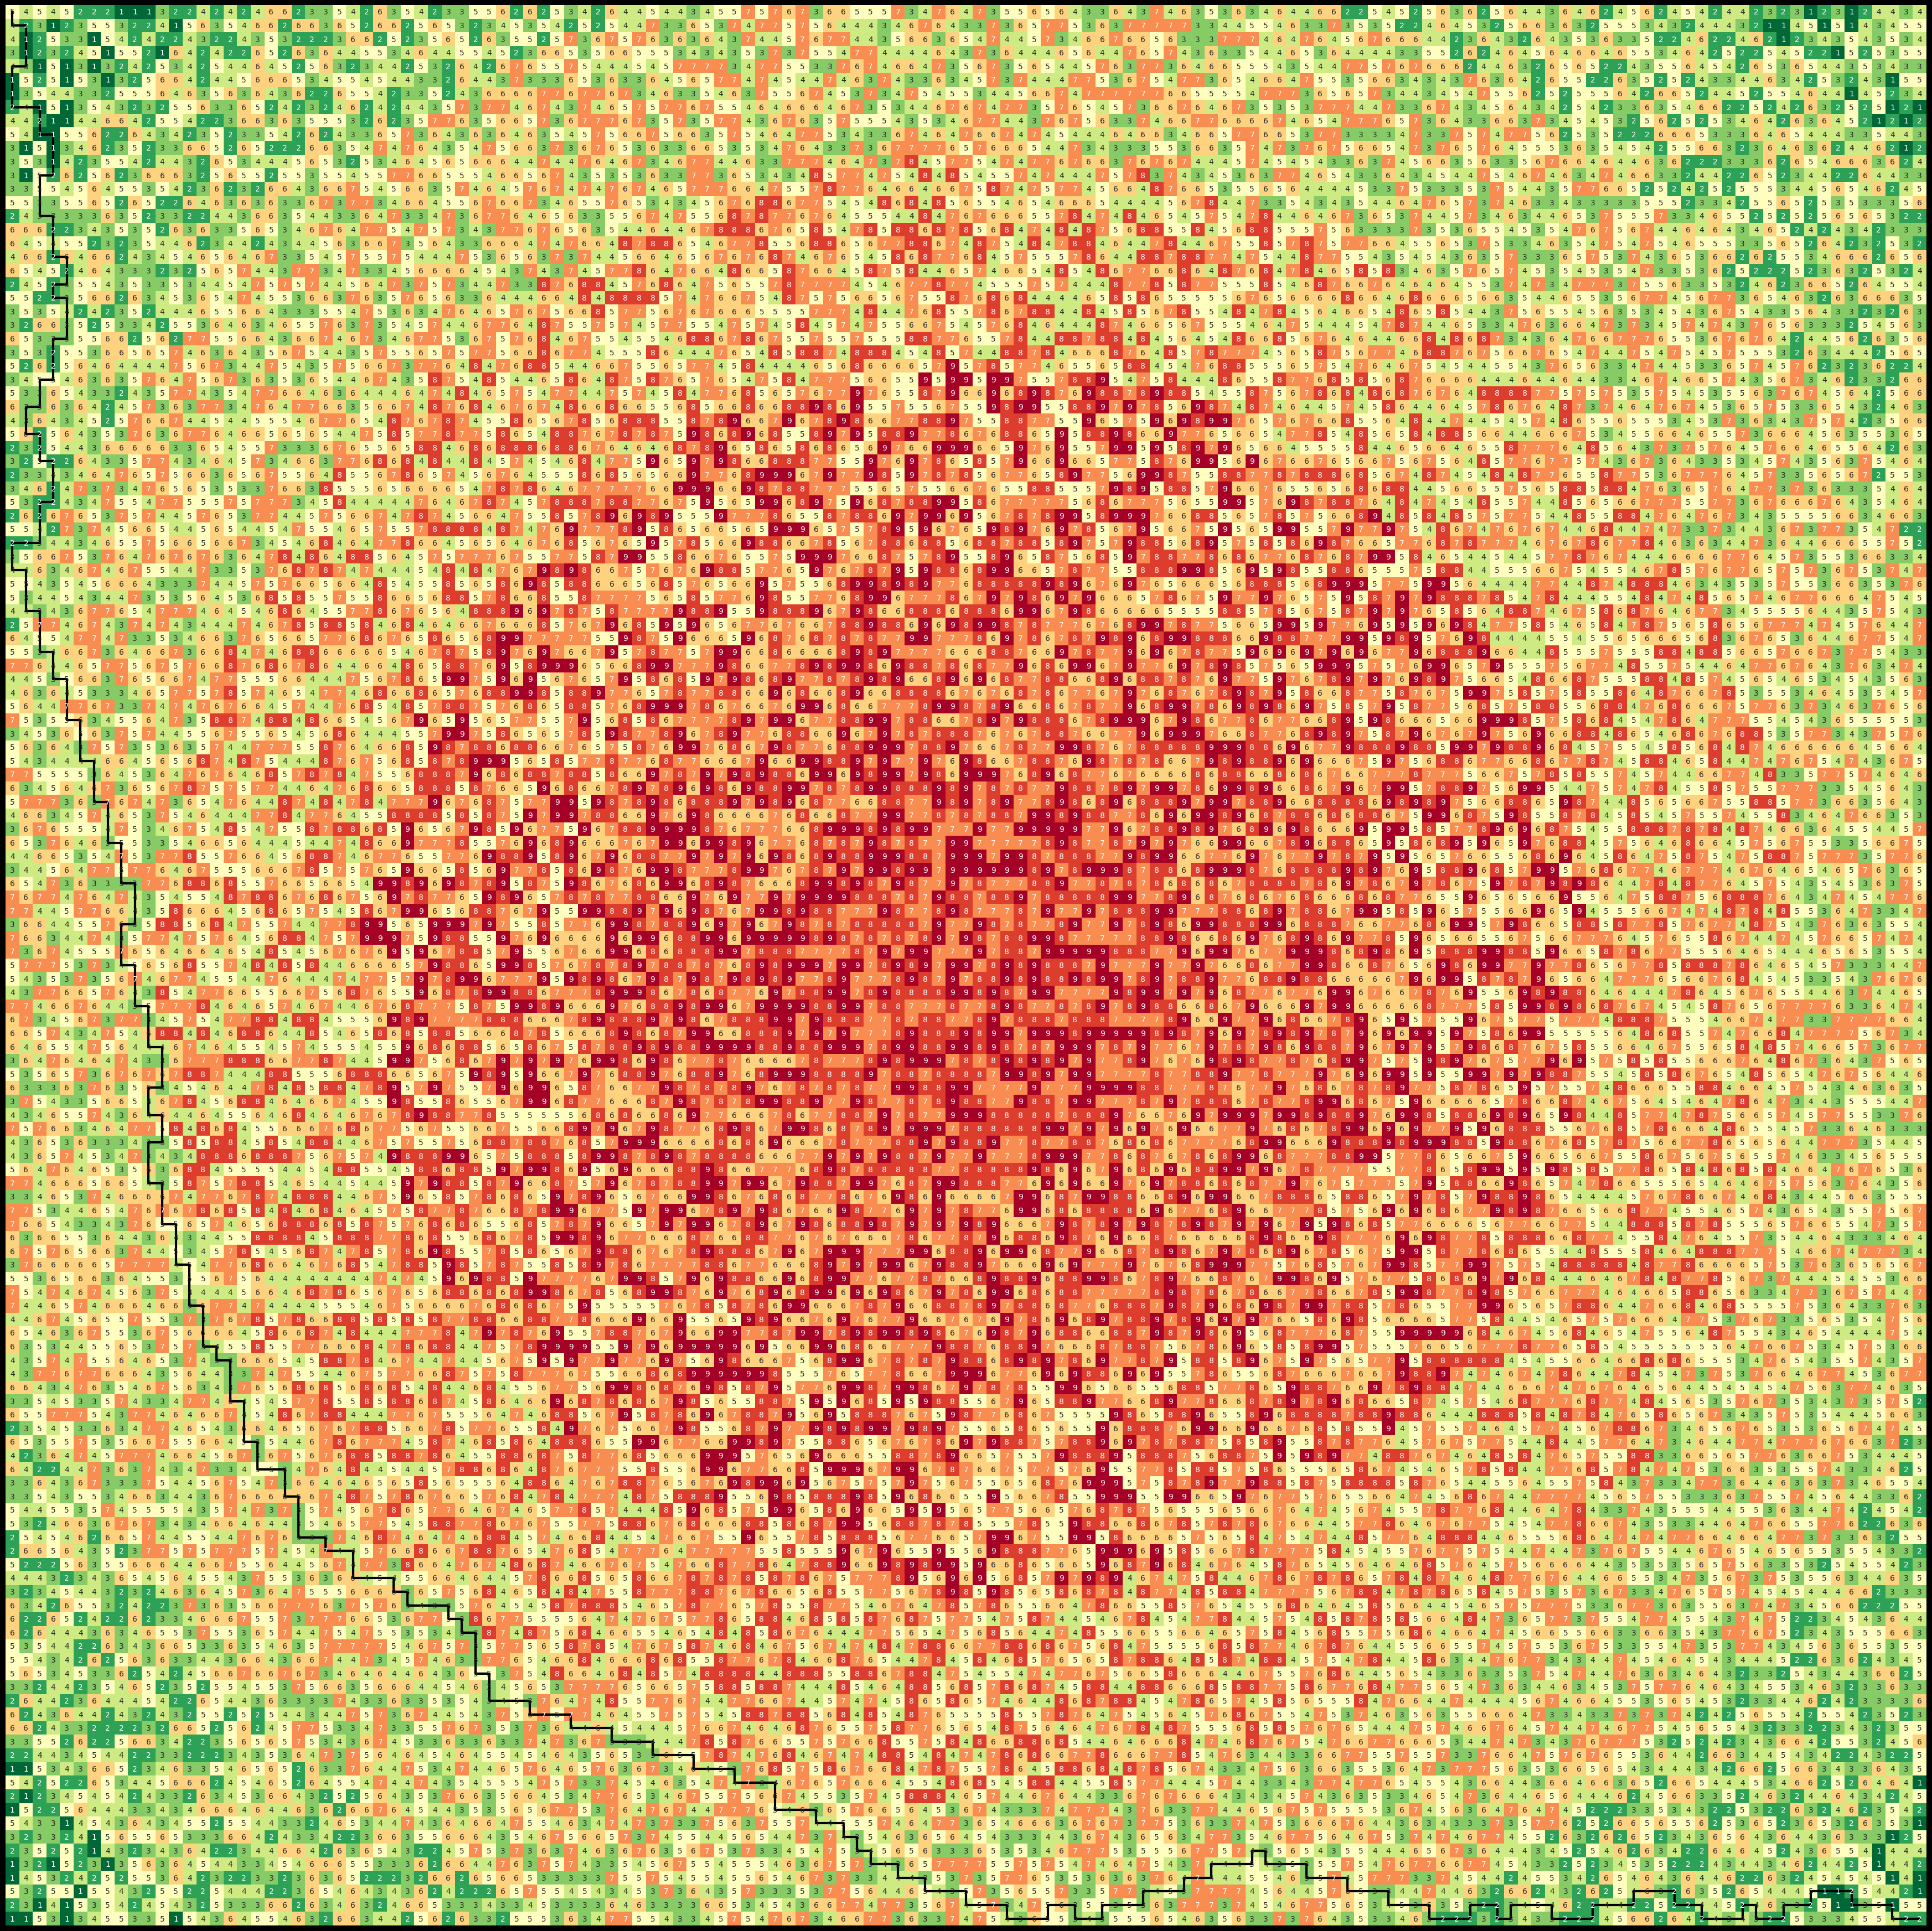

In [44]:
plot_heatmap(input_df, path)

## Part 2

The crucibles of lava simply aren't large enough to provide an adequate supply of lava to the machine parts factory. Instead, the Elves are going to upgrade to ultra crucibles.

Ultra crucibles are even more difficult to steer than normal crucibles. Not only do they have trouble going in a straight line, but they also have trouble turning!

Once an ultra crucible starts moving in a direction, it needs to move a minimum of four blocks in that direction before it can turn (or even before it can stop at the end). However, it will eventually start to get wobbly: an ultra crucible can move a maximum of ten consecutive blocks without turning.

In the above example, an ultra crucible could follow this path to minimize heat loss:

```
2>>>>>>>>1323
32154535v5623
32552456v4254
34465858v5452
45466578v>>>>
143859879845v
445787698776v
363787797965v
465496798688v
456467998645v
122468686556v
254654888773v
432267465553v
```
In the above example, an ultra crucible would incur the minimum possible heat loss of 94.

Here's another example:

```
111111111111
999999999991
999999999991
999999999991
999999999991
```
Sadly, an ultra crucible would need to take an unfortunate path like this one:

```
1>>>>>>>1111
9999999v9991
9999999v9991
9999999v9991
9999999v>>>>
```
This route causes the ultra crucible to incur the minimum possible heat loss of 71.

Directing the ultra crucible from the lava pool to the machine parts factory, what is the least heat loss it can incur?

In [95]:
class UltraCruciblePusher(CruciblePusher):
    def get_available_moves(self, from_state: PathState) -> dict[str, tuple[int, int]]:
        moves = {}
        directions = {
            "north": "south",
            "south": "north",
            "east": "west",
            "west": "east",
        }
        for direction, opposite_direction in directions.items():
            if from_state.direction == opposite_direction:
                # can't go backwards
                continue
            if from_state.steps_since_turn < 3:
                if from_state.direction != direction:
                    # can't turn yet, keep going forward until we've taken 4 steps
                    continue
            if from_state.steps_since_turn > 9:
                # can't go forward if we've already gone 10 steps
                if from_state.direction == direction:
                    continue

            dir_position = getattr(self, f"{direction}_position")
            if (next_position := dir_position(from_state.position)) is not None:
                moves[direction] = next_position

        return moves

    def calc_lowest_heat_loss(self, from_position: tuple[int, int], direction: str) -> int:
        start_state = PathState(
            heat_loss=0,
            position=from_position,
            direction=direction,
            steps_since_turn=0,
        )
        path_states = [start_state]

        while path_states:
            current_state = path_states.pop(0)
            # NEW: we have to make sure the last leg of the path isn't cut short
            if current_state.position == self.end_position and current_state.steps_since_turn >= 3:
                # hooray, we did it. return the heat loss and work backwards to get the path taken
                final_heat_loss = current_state.heat_loss

                path_taken = []
                while current_state is not None:
                    path_taken.append(current_state.position)
                    current_state: PathState = current_state.previous_state
                path_taken.reverse()

                return final_heat_loss, path_taken

            available_moves = self.get_available_moves(current_state)
            for to_direction, to_position in available_moves.items():
                heat_loss = current_state.heat_loss + self.df.iloc[to_position]

                steps_since_turn = current_state.steps_since_turn
                if to_direction == current_state.direction:
                    steps_since_turn += 1
                else:
                    # reset the steps since last turn
                    steps_since_turn = 0

                next_state = PathState(
                    heat_loss=heat_loss,
                    position=to_position,
                    direction=to_direction,
                    steps_since_turn=steps_since_turn,
                    previous_state=current_state,
                )
                # easier lookup than using a dataclass
                state_key = (
                    f"{next_state.position}{next_state.direction}{next_state.steps_since_turn}"
                )
                if state_key not in self.state_keys:
                    path_states.append(next_state)
                    self.state_keys.add(state_key)

                path_states = sorted(path_states, key=lambda s: s.heat_loss)

        # no path found
        return -1, []


test_input = """
2413432311323
3215453535623
3255245654254
3446585845452
4546657867536
1438598798454
4457876987766
3637877979653
4654967986887
4564679986453
1224686865563
2546548887735
4322674655533""".strip()
test_df = str_to_df(test_input)
test_pusher = UltraCruciblePusher(test_df)
test_heat_loss, test_path = test_pusher.calc_lowest_heat_loss(test_pusher.start_position, "east")
assert test_heat_loss == 94, test_heat_loss


test_input2 = """
111111111111
999999999991
999999999991
999999999991
999999999991""".strip()
test_df2 = str_to_df(test_input2)
test_pusher2 = UltraCruciblePusher(test_df2)
test_heat_loss2, test_path2 = test_pusher2.calc_lowest_heat_loss(
    test_pusher2.start_position, "east"
)
assert test_heat_loss2 == 71, test_heat_loss2

In [96]:
pusher2 = UltraCruciblePusher(input_df)
heat_loss2, path2 = pusher2.calc_lowest_heat_loss(pusher2.start_position, "east")

# 1362 too low
# 1402 too high
heat_loss2

1362

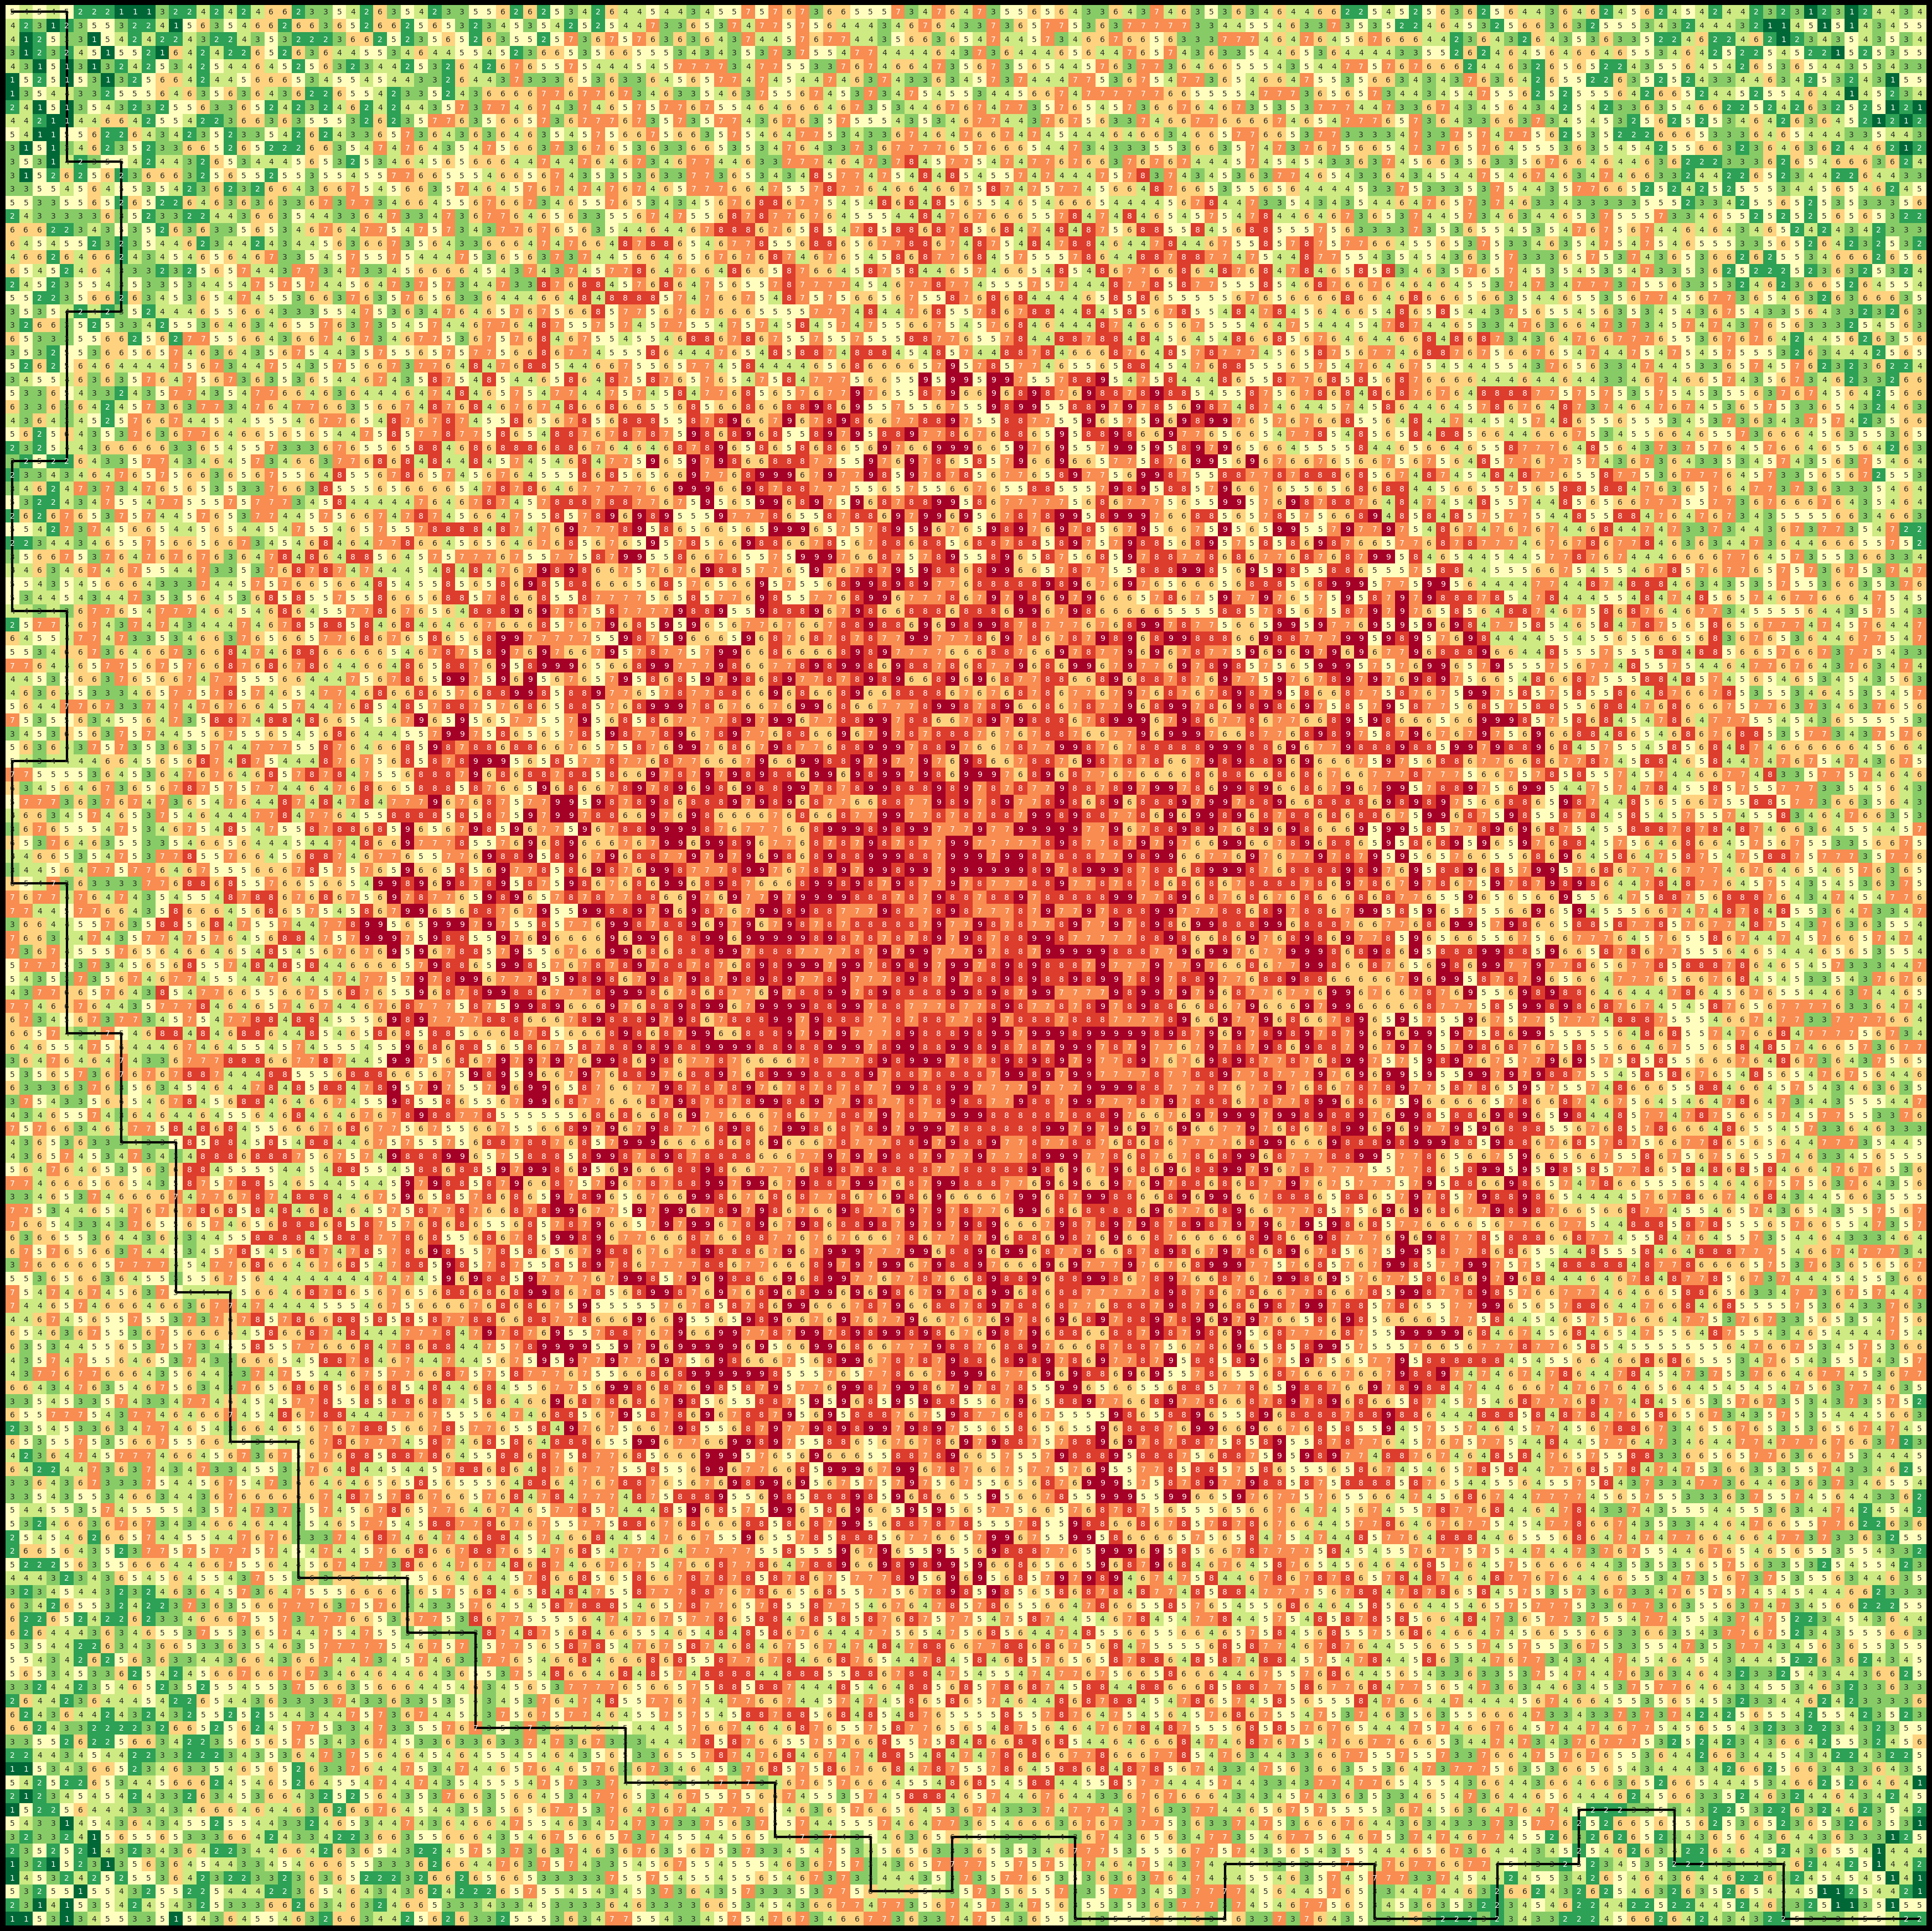

In [97]:
plot_heatmap(input_df, path2)